In [ ]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from src.model_specpred import SpectrumPredictor
from src.utils_model import lorentzian, spec_to_Sqt, batch_spec_to_Sqt

from matplotlib.colors import to_rgb, to_rgba

from matplotlib.colors import Normalize
from scipy.interpolate import interp1d
import torch
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm

torch.set_default_dtype(torch.float64)

: 

In [2]:
import seaborn
palette_crest = seaborn.color_palette(palette='crest')
palette_flare = seaborn.color_palette(palette='flare')

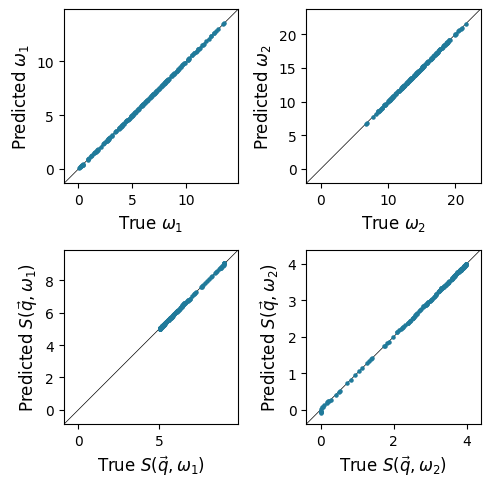

In [3]:
data = torch.load("data/CrI3/20221110.pt")
X = data['param'][:,:2]
Y = torch.cat((data['omega'], data['inten']), dim=1)

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=1/5, random_state=42)

train_dataset = TensorDataset(X_train, Y_train)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

model_spec = SpectrumPredictor.load_from_checkpoint("training_logs/lightning_logs/version_2/checkpoints/epoch=9533-step=209748.ckpt")

loss_val = []
Y_val_pred = []
with torch.no_grad():
    for x_val, y_val in zip(X_val, Y_val):
        y_val_pred = model_spec(x_val).detach()
        loss_val.append((y_val_pred - y_val).abs().mean().item())
        Y_val_pred.append(y_val_pred)
Y_val_pred = torch.vstack(Y_val_pred)

labels = [r'$\omega_1$', r'$\omega_2$', r'$S(\vec{q},\omega_{1})$', r'$S(\vec{q},\omega_{2})$']

fig = plt.figure(figsize=(5,5))
gs = plt.GridSpec(2,2)
for i in range(4):
    ax = fig.add_subplot(gs[i])
    ax.plot([-100,100], [-100,100], 'k', linewidth=0.5, zorder=0)
    ax.scatter(Y_val[:,i], Y_val_pred[:,i], s=5, color="#207A9A", zorder=10)
    ax.set_aspect('equal')
    ax.set_xlim([-0.1*Y_val[:,i].max(), 1.1*Y_val[:,i].max()])
    ax.set_ylim([-0.1*Y_val[:,i].max(), 1.1*Y_val[:,i].max()])
    ax.set_xlabel(f"True {labels[i]}", fontsize=12)
    ax.set_ylabel(f"Predicted {labels[i]}", fontsize=12)

fig.tight_layout()
fig.savefig("figs/paper/network_hist2d.pdf", bbox_inches='tight')

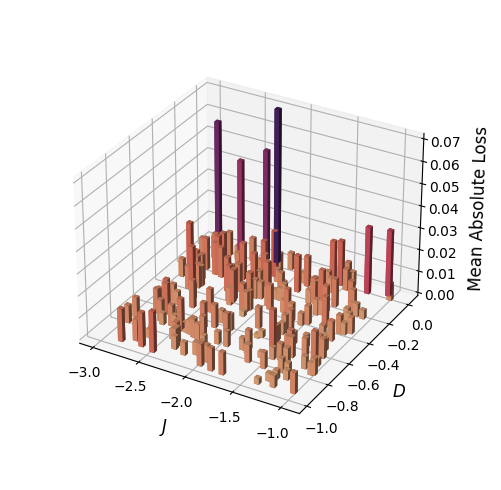

In [4]:
xpos = X_val[:,0].cpu().numpy()
ypos = X_val[:,1].cpu().numpy()
dz = np.asarray(loss_val)
zpos = np.zeros_like(dz)
dx, dy = 0.05, 0.025

cmap = seaborn.color_palette(palette='flare', as_cmap=True)
# Normalize data
norm = Normalize(vmin=dz.min(), vmax=dz.max())
rgba_values = cmap(norm(dz))

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(projection='3d')
ax.bar3d(xpos, ypos, zpos, dx, dy, dz, zsort='average', color=rgba_values)
ax.set_xlabel("$J$", fontsize=12)
ax.set_xticks([-3,-2.5,-2,-1.5,-1])
ax.xaxis.labelpad=10
ax.set_ylabel("$D$", fontsize=12)
ax.yaxis.labelpad=10
ax.set_zlabel("Mean Absolute Loss", fontsize=12)
ax.zaxis.labelpad=10
ax.dist = 12
fig.tight_layout()

# fig.savefig("figs/paper/network_loss_bar3d.pdf", bbox_inches='tight')

In [5]:
import optbayesexpt as obe
from src.utils_model import construct_fc_net, array2tensor, tensor2array
from src.bayes import BayesianInference, jit_batch_spec_to_Sqt

In [6]:
times = np.arange(0,5,0.01)
settings = (times, )
parameters = (
    np.random.uniform(-3.0, 0.0, 1001),
    np.random.uniform(-1.0,-0.0, 1001),
    np.random.uniform( 0.0, 1.0, 1001)
    )
# parameters = (
#     np.random.uniform(-0.5, 0.0, 1001),
#     np.random.uniform(-0.5,-0.0, 1001),
#     np.random.uniform( 0.0, 1.0, 1001)
#     )

In [7]:
from numba import njit, prange

@njit
def interp_nb(t, tp, Sp):
    return np.interp(t, tp, Sp)

@njit
def get_I_conv_at_t(t, tp, Sp, pulse_width):
    t_around = np.linspace(t-pulse_width/2, t+pulse_width/2, int(pulse_width/0.01))
    I_out = np.trapz(np.abs(interp_nb(t_around, tp, Sp))**2, t_around) / pulse_width
    return I_out

@njit(parallel=True)
def get_I_conv(t, tp, Sp, pulse_width):
    if isinstance(t, (int, float)):
        t = np.asarray([t,])
    I_out = np.zeros_like(t)
    for i_t in prange(len(t)):
        I_out[i_t] = get_I_conv_at_t(t[i_t], tp, Sp, pulse_width)
    # I_0 = get_I_conv_at_t(func_S, 0., pulse_width)
    # I_out = I_out / I_0
    return I_out

In [8]:
def prepare_sample(idx, pulse_width=0.1, visualize=False):
    # prepare Sqt energies and intensities
    x_val = X_val[idx]
    y_val = Y_val[idx]
    gamma = 0.1
    noise_level = 10.0

    omega_val, inten_val = torch.split(y_val, y_val.shape[0]//2)
    true_pars = x_val.cpu().numpy().tolist() + [gamma,]

    # setup time for Sqt computation
    dt = times[1]-times[0]
    times_extended = np.arange(times[0]-pulse_width, times[-1]+pulse_width, dt)
    times_extended_tensor = torch.from_numpy(times_extended)

    # S and |S^2| with NO pulse shape convolution
    true_S = jit_batch_spec_to_Sqt(omega_val, inten_val, times_extended_tensor).sum(dim=1).squeeze() * \
        torch.exp(- gamma * times_extended_tensor)
    true_S = true_S.detach().cpu().numpy()
    func_I_noconv = lambda t: interp_nb(t, times_extended, np.abs(true_S)**2)

    # S and |S^2| with pulse shape convolution
    true_I_conv = get_I_conv(times, times_extended, true_S, pulse_width)
    func_I_conv = lambda t: interp_nb(t, times, true_I_conv)

    if visualize:
        fig, ax = plt.subplots(1,1)
        ax.plot(times_extended, np.abs(true_S)**2)
        ax.plot(times, true_I_conv)

    return np.asarray(true_pars), func_I_conv, func_I_noconv

def measure_function(sets, pars, cons, func):
    """ Evaluates a trusted model of the experiment's output
    The equivalent of a fit function. The argument structure is
    required by OptBayesExpt.
    Args:
        sets: A tuple of setting values, or a tuple of settings arrays
        pars: A tuple of parameter arrays or a tuple of parameter values
        cons: A tuple of floats
    Returns:  the evaluated function
    """
    # unpack the settings
    # t, = sets
    # unpack model parameters
    t, = sets
    if isinstance(t, (int, float)):
        t = np.array([t,])
    else:
        t = np.atleast_1d(tensor2array(t))
    I_pred = func(t)
    return I_pred

In [9]:
from tqdm import tqdm

pulse_width = 0.1
noise_level = 5.0
N_steps_bayes = 100

comparison_dict = {
    'param_mean': [],
    'param_std' : [],
    'param_true': []
}
for idx in range(len(X_val)):
    print(f"getting {idx}-th sample.\n")
    param_true, func_I_conv, func_I_noconv = prepare_sample(idx, pulse_width=pulse_width)
    # print("true parameters are:", true_pars)
    obe_sim = obe.MeasurementSimulator(
        lambda s, p, c: measure_function(s, p, c, func_I_conv), param_true, (), noise_level=noise_level)
    obe_sim_noisefree = obe.MeasurementSimulator(
        lambda s, p, c: measure_function(s, p, c, func_I_conv), param_true, (), noise_level=0.0)
    # comparison_dict['']
    bayes = BayesianInference(model_spec, settings, parameters, pulse_width=pulse_width)
    
    bayes.obe_model.set_selection_method('optimal')
    particles_hist, p_weights_hist = bayes.run_N_steps_OptBayesExpt(N_steps_bayes, obe_sim, ret_particles=True)
    param_mean = np.asarray(bayes.param_mean)
    param_std = np.asarray(bayes.param_std)

    comparison_dict['param_mean'].append(param_mean[None])
    comparison_dict['param_std'].append(param_std[None])
    comparison_dict['param_true'].append(param_true)
    
    if idx == 20:
        break

for key in comparison_dict.keys():
    comparison_dict[key] = np.vstack(comparison_dict[key])


getting 0-th sample.



/tmp/ipykernel_107543/2525657087.py:15: NumbaExperimentalFeatureWarning: Use of isinstance() detected. This is an experimental feature.
  if isinstance(t, (int, float)):


KeyboardInterrupt: 

In [ ]:
import pickle

with open('data/benchmark/bayesian_baseline.pkl', 'wb') as f:
    pickle.dump(comparison_dict, f)

In [ ]:
l1_diff = np.abs(comparison_dict['param_mean'] - comparison_dict['param_true'][:,None,:])

In [ ]:
plt.plot(l1_diff.mean(axis=0)[:,2])

In [ ]:
comparison_dict_rdn = {
    'param_mean': [],
    'param_std' : [],
    'param_true': []
}
for idx in range(len(X_val)):
    param_true, func_I_conv, func_I_noconv = prepare_sample(idx, pulse_width=pulse_width)
    # print("true parameters are:", true_pars)
    obe_sim = obe.MeasurementSimulator(
        lambda s, p, c: measure_function(s, p, c, func_I_conv), param_true, (), noise_level=noise_level)
    obe_sim_noisefree = obe.MeasurementSimulator(
        lambda s, p, c: measure_function(s, p, c, func_I_conv), param_true, (), noise_level=0.0)
    bayes = BayesianInference(model_spec, settings, parameters, pulse_width=pulse_width)
    
    bayes.obe_model.set_selection_method('random')
    particles_hist, p_weights_hist = bayes.run_N_steps_OptBayesExpt(N_steps_bayes, obe_sim, ret_particles=True)
    param_mean = np.asarray(bayes.param_mean)
    param_std = np.asarray(bayes.param_std)

    comparison_dict_rdn['param_mean'].append(param_mean[None])
    comparison_dict_rdn['param_std'].append(param_std[None])
    comparison_dict_rdn['param_true'].append(param_true)

    # if idx > 20:
    #     break

In [ ]:

with open('data/benchmark/bayesian_random.pkl', 'wb') as f:
    pickle.dump(comparison_dict_rdn, f)

In [ ]:
l1_diff_rdn = np.abs(np.vstack(comparison_dict_rdn['param_mean']) - np.vstack(comparison_dict_rdn['param_true'])[:,None,:])

In [ ]:
plt.plot(l1_diff.mean(axis=0)[:,2])
plt.plot(l1_diff_rdn.mean(axis=0)[:,2])

In [ ]:
bayes = BayesianInference(model_spec, settings, parameters, pulse_width=pulse_width)
particles_hist, p_weights_hist = bayes.run_N_steps_OptBayesExpt(50, obe_sim, ret_particles=True)
# print(bayes.obe_model.mean(), bayes.obe_model.std())

param_mean = np.asarray(bayes.param_mean)
param_std = np.asarray(bayes.param_std)


In [ ]:
param_mean.shape

In [ ]:
plt.plot(param_mean - true_pars)

In [ ]:
param_mean = np.asarray(bayes.param_mean)
param_std = np.asarray(bayes.param_std)

idx_plot = 6
utility_plot = bayes.utility_list[idx_plot]
utility_plot = 20 * utility_plot / utility_plot.max()
# utility_plot = np.exp(utility_plot - utility_plot.max()) *20

measured_settings, measured_observables = bayes.get_all_measurements()
_, measurements_noisefree = bayes.measure_all_settings(obe_sim_noisefree)
_, measurements_predicted = bayes.predict_all_settings(param_mean[idx_plot-1])


In [ ]:
maxiter = len(param_mean)

colors = [palette_crest[0], palette_crest[-3], palette_flare[0]]

label_lst = ["$J$", "$D$", "$\gamma$"]
fig, ax = plt.subplots(1,1,figsize=(5,3))

ax.plot(times.squeeze(), measurements_noisefree, 'k--', label="Ground Truth", zorder=5, linewidth=1)
# # ax[1].plot(time_val, model_function((time_val,), obe_model.mean(), ()), 'r--', label="Ground Truth")
ax.plot(times.squeeze(), measurements_predicted, color=palette_flare[0], label="Model Prediction", zorder=5)
ax.fill_between(times.squeeze(), measurements_predicted-utility_plot, measurements_predicted+utility_plot, color=palette_flare[0], zorder=1, alpha=0.25)
ax.scatter(measured_settings.squeeze()[:idx_plot], measured_observables.squeeze()[:idx_plot], label="Measured", s=30, color=palette_crest[-3], zorder=10)
ax.scatter(measured_settings.squeeze()[idx_plot], measured_observables.squeeze()[idx_plot], label="Proposed", s=50, color=palette_flare[-1], zorder=20, marker='^')
ax.legend(fontsize=10, ncol=2)
ax.set_xlabel('$t$', fontsize=15)
ax.set_ylim([-15, measurements_noisefree.max()+25])
ax.set_ylabel(r'$\left|\bar{S}(q,t)\right|^{2}$', fontsize=15)
ax.set_title(f"Iteration {idx_plot}", fontsize=15)

fig.tight_layout()
# fig.savefig(f'figs/paper/exp_steering_sqt_sample{idx}_iter{idx_plot}.pdf')

In [ ]:
maxiter = len(param_mean)

colors = [palette_crest[0], palette_crest[-3], palette_flare[0]]

label_lst = ["$J$", "$D$", "$\gamma$"]
fig, ax = plt.subplots(1,1,figsize=(5,3))
for i in range(param_mean.shape[1]):
    ax.fill_between(np.arange(maxiter), param_mean[:,i]-param_std[:,i], param_mean[:,i]+param_std[:,i], color=colors[i], alpha=0.2)
    ax.hlines(true_pars[i], -100, 100*maxiter, linestyles='--', color='gray')
    ax.plot(np.arange(maxiter), param_mean[:,i], color=colors[i], label=label_lst[i])
ax.set_xlim([-0.*maxiter, 1.2*maxiter])
ax.legend(loc='best', fontsize=10)
ax.set_xlabel("Iterations", fontsize=15)
ax.set_ylabel("Parameters", fontsize=15)

fig.tight_layout()
# fig.savefig(f'figs/paper/exp_steering_paramhist_sample{idx}.pdf')

In [ ]:
gd_loss_hist, gd_param_hist = bayes.run_gradient_desc_on_current_measurements(
    200, lr=0.001, batch_size=bayes.obe_model.n_particles, init_bayes_guess=False)

In [ ]:
def normalize(arr, arr_min, arr_max):
    delta_arr = (arr.max() - arr.min())
    if delta_arr > 0:
        arr_new = (arr - arr.min()) / delta_arr
        arr_new = arr_new * (arr_max - arr_min) + arr_min
        return arr_new
    else:
        return np.ones_like(arr)

In [ ]:
cmap = seaborn.color_palette(palette='flare', as_cmap=True)
norm = Normalize(0, len(particles_hist)-1)

In [ ]:
def plot_scatter_series(data, special_point=None, labels=None, special_point_label=None, save_name=None):
    data_size, num_points = data.shape[0], data.shape[-1]
    norm = Normalize(0, data_size-1)
    fig, ax = plt.subplots(1,1,figsize=(5,5))
    if labels is not None:
        assert len(labels) == data_size
    
    for i in range(data_size):
        colors = np.array(cmap(norm(i)))[np.newaxis,:].repeat(num_points, axis=0)
        # colors[:,-1] = normalize(p_weights_hist[i], 0.25, 0.5)
        # colors[:,-1] = 0.25
        ax.scatter(data[i,0], data[i,1], color=colors, s=10, label=None if labels is None else labels[i])
    if special_point is not None:
        ax.scatter(special_point[0], special_point[1], color="#70B6A1", marker='*', s=30)
    if labels is not None:
        ax.legend(ncol = 2, fontsize=10)
    ax.set_xlabel("$J$", fontsize=15)
    ax.set_ylabel("$D$", fontsize=15)
    if save_name is not None:
        fig.savefig(save_name, dpi=300, bbox_inches='tight')

In [ ]:
# indices = np.linspace(0, len(particles_hist)-1, 5).astype('int')
indices = [0, 5, 6, 49]
plot_scatter_series(particles_hist[indices], labels=[f'Iteration {i}' for i in indices], save_name=f'figs/paper/baysian_population_evolution_sample{idx}.pdf')

In [ ]:
gd_param_hist_for_plot = torch.cat((gd_param_hist['J'][:,None], gd_param_hist['D'][:,None]), dim=1).numpy()
indices = np.linspace(0, len(gd_param_hist_for_plot)-1, 5).astype('int')
plot_scatter_series(gd_param_hist_for_plot[indices], save_name='figs/paper/gd_first_round.pdf')

In [ ]:
ranges_J = [bayes.forward_model.J.min().item()-0.25, bayes.forward_model.J.max().item()+0.25]
ranges_D = [bayes.forward_model.D.min().item()-0.25, bayes.forward_model.D.max().item()+0.25]

fig, ax = plt.subplots(1,1)
ax.hist2d(
    bayes.forward_model.J.squeeze().detach().cpu().numpy(), 
    bayes.forward_model.D.squeeze().detach().cpu().numpy(), 
    bins=[int((ranges_J[1]-ranges_J[0])//0.05),int((ranges_D[1]-ranges_D[0])//0.05)], range=[ranges_J, ranges_D],
    cmap=plt.colormaps['bone']
)
ax.vlines(x_val[0], -10, 10, colors='white', linestyle='--')
ax.hlines(x_val[1], -10, 10, colors='white', linestyle='--')
ax.set_xlim(ranges_J)
ax.set_xlabel("$J$", fontsize=18)
ax.set_ylim(ranges_D)
ax.set_ylabel("$D$", fontsize=18)
ax.set_aspect('equal')
fig.tight_layout()

In [ ]:
bayes.update_OptBayesExpt_particles()
print(bayes.obe_model.mean(), bayes.obe_model.std())
particles_hist, p_weights_hist = bayes.run_N_steps_OptBayesExpt(50, obe_sim, ret_particles=True)
print(bayes.obe_model.mean(), bayes.obe_model.std())

In [ ]:
indices = np.linspace(0, len(particles_hist)-1, 10).astype('int')
plot_scatter_series(particles_hist[indices], special_point=x_val,save_name='figs/paper/baysian_second_round.pdf')

In [ ]:
_, _ = bayes.run_gradient_desc_on_current_measurements(100, batch_size=bayes.obe_model.n_particles, init_bayes_guess=False)

In [ ]:
ranges_J = [bayes.forward_model.J.min().item()-0.25, bayes.forward_model.J.max().item()+0.25]
ranges_D = [bayes.forward_model.D.min().item()-0.25, bayes.forward_model.D.max().item()+0.25]

fig, ax = plt.subplots(1,1)
ax.hist2d(
    bayes.forward_model.J.squeeze().detach().cpu().numpy(), 
    bayes.forward_model.D.squeeze().detach().cpu().numpy(), 
    bins=[int((ranges_J[1]-ranges_J[0])//0.05),int((ranges_D[1]-ranges_D[0])//0.05)], range=[ranges_J, ranges_D],
    cmap=plt.colormaps['bone']
)
ax.vlines(x_val[0], -10, 10, colors='white', linestyle='--')
ax.hlines(x_val[1], -10, 10, colors='white', linestyle='--')
ax.set_xlim(ranges_J)
ax.set_xlabel("$J$", fontsize=18)
ax.set_ylim(ranges_D)
ax.set_ylabel("$D$", fontsize=18)
ax.set_aspect('equal')
fig.tight_layout()

In [ ]:
param_mean = np.asarray(bayes.param_mean)
param_std = np.asarray(bayes.param_std)

measured_settings, measured_observables = bayes.get_all_measurements()
_, measurements_noisefree = bayes.measure_all_settings(obe_sim_noisefree)
_, measurements_predicted = bayes.predict_all_settings()

In [ ]:
maxiter = len(param_mean)

colors = [palette_crest[0], palette_crest[-3], palette_flare[0]]

label_lst = ["$J$", "$D$", "$\gamma$"]
fig, ax = plt.subplots(2,1,figsize=(6,6))
for i in range(param_mean.shape[1]):
    ax[0].fill_between(np.arange(maxiter), param_mean[:,i]-param_std[:,i], param_mean[:,i]+param_std[:,i], color=colors[i], alpha=0.2)
    ax[0].hlines(true_pars[i], -100, 100*maxiter, linestyles='--', color='gray')
    ax[0].plot(np.arange(maxiter), param_mean[:,i], color=colors[i], label=label_lst[i])
ax[0].set_xlim([-0.*maxiter, 1.2*maxiter])
ax[0].legend()
ax[0].set_xlabel("Iterations", fontsize=12)
ax[0].set_ylabel("Parameters", fontsize=12)

ax[1].plot(times.squeeze(), measurements_noisefree, 'k--', label="Ground Truth", zorder=5, linewidth=1)
# # ax[1].plot(time_val, model_function((time_val,), obe_model.mean(), ()), 'r--', label="Ground Truth")
ax[1].plot(times.squeeze(), measurements_predicted, color=palette_flare[0], label="Model Prediction", zorder=1)
ax[1].scatter(measured_settings.squeeze(), measured_observables.squeeze(), label="Measurement", s=12, color=palette_crest[-3], zorder=10)
ax[1].legend(fontsize=9)
ax[1].set_xlabel('$t$', fontsize=12)
ax[1].set_ylabel(r'$\left|\bar{S}(q,t)\right|^{2}$', fontsize=12)

fig.tight_layout()
fig.savefig('figs/paper/exp_steering.pdf')

In [ ]:
from matplotlib.animation import FuncAnimation

fig = plt.Figure(figsize=(6,6)) # this creates a Figure() instance
# ax = fig.add_subplot()
gs = fig.add_gridspec(2,1)
ax0 = fig.add_subplot(gs[0])
ax1 = fig.add_subplot(gs[1])

ax0.set_xlim([-0.*maxiter, 1.2*maxiter])
ax0.set_ylim([-3.1,1.0])
ax0.set_xlabel("Iterations", fontsize=18)
ax0.set_ylabel("Parameters", fontsize=18)
for i in range(param_mean.shape[1]):
    # ax[0].fill_between(np.arange(maxiter), param_mean[:,i]-param_std[:,i], param_mean[:,i]+param_std[:,i], alpha=0.2)
    ax0.hlines(true_pars[i], -100, 100*maxiter, linestyles='--', color='gray')

ax1.set_xlim([0, 1.1*times.max()])
ax1.plot(times, true_S, color='k', label="Ground Truth")
ax1.set_xlabel("$t$", fontsize=18)
ax1.set_ylabel("$S(q,t)$", fontsize=18)
line_pred, = ax1.plot([], [], lw=2)
sc = ax1.scatter([], [], color='C2', s=12)

line_J, = ax0.plot([], [], lw=2)
line_D, = ax0.plot([], [], lw=2)
line_gamma, = ax0.plot([], [], lw=2)
fig.tight_layout()

def init():
    i=1
    line_J.set_data(np.arange(i), param_mean[:i,0])
    line_D.set_data(np.arange(i), param_mean[:i,1])
    line_gamma.set_data(np.arange(i), param_mean[:i,2])
    line_J.set_label(label_lst[0])
    line_D.set_label(label_lst[1])
    line_gamma.set_label(label_lst[2])
    ax0.legend(loc='center right')
    sc.set_offsets(np.concatenate((measured_settings.squeeze()[:i,None], measured_observables.squeeze()[:i,None]),axis=1))
    line_pred.set_data(times, bayes.model_predictions_on_obe_mean[i])
    sc.set_zorder(10)
    return line_J, line_D, line_gamma, sc, line_pred
def animate(i):
    line_J.set_data(np.arange(i), param_mean[:i,0])
    line_D.set_data(np.arange(i), param_mean[:i,1])
    line_gamma.set_data(np.arange(i), param_mean[:i,2])
    sc.set_offsets(np.concatenate((measured_settings.squeeze()[:i,None], measured_observables.squeeze()[:i,None]),axis=1))
    line_pred.set_data(times, bayes.model_predictions_on_obe_mean[i])
    sc.set_zorder(10)
    return line_J, line_D, line_gamma, sc, line_pred

anim = FuncAnimation(
    fig, animate, init_func=init,
    frames=maxiter, interval=100, blit=True)

anim.save(f'out/gifs/sequential_J={true_pars[0]:.3f}_D={true_pars[1]:.3f}_gamma={true_pars[2]:.3f}.gif', dpi=300)